# Section 7

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 16,
    'text.latex.preamble': r"\usepackage{amsmath}"
})

In [2]:
import irbasis3

## Generate IR basis by singular value expansion

In [3]:
# Create kenerl for lambda_ = 100 and beta = 10
# The default value of eps ``cutoff for singular values" is
# set to 2.2e-16.
# In this sample, we compute fewer basis functions.
lambda_ = 100
beta = 10
wmax = lambda_/beta
K = irbasis3.KernelFFlat(lambda_=100)
basis = irbasis3.FiniteTempBasis(
    K, statistics="F", beta=beta, eps=1e-10)
print(basis.size)

30


## Fitting $\rho(\omega)$

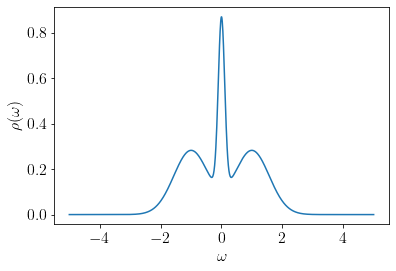

In [4]:
# Three Gaussian peaks (normalized to 1)
gaussian = lambda x, mu, sigma:\
    np.exp(-((x-mu)/sigma)**2)/(np.sqrt(np.pi)*sigma)

rho = lambda omega: 0.2*gaussian(omega, 0.0, 0.15) + \
    0.4*gaussian(omega, 1.0, 0.8) + 0.4*gaussian(omega, -1.0, 0.8)

omegas = np.linspace(-5, 5, 1000)
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\rho(\omega)$")
plt.plot(omegas, rho(omegas))
#plt.tight_layout()
#plt.savefig("section7_rho_omega.pdf")

Text(0, 0.5, '$|\\rho_l|$')

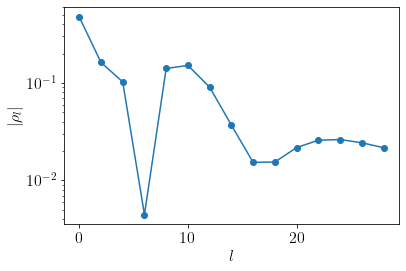

In [5]:
rhol = basis.v.overlap(rho)
plt.semilogy(np.arange(0,basis.size,2), np.abs(rhol[::2]), marker="o")
plt.xlabel(r"$l$")
plt.ylabel(r"$|\rho_l|$")

Text(0, 0.5, '$|g_l|$')

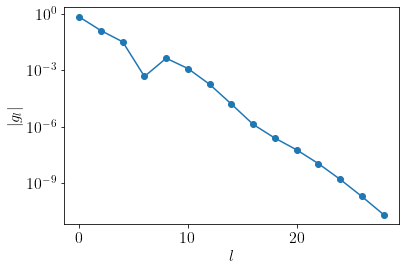

In [6]:
gl = -basis.s * rhol
plt.semilogy(np.arange(0,basis.size,2), np.abs(gl[::2]), marker='o')
plt.xlabel(r'$l$')
plt.ylabel(r'$|g_l|$')

## From IR to $\tau$

In [7]:
def eval_gtau(taus):
    uval = basis.u(taus) #(nl, ntau)
    return uval.T @ gl

Text(0, 0.5, '$G(\\tau)$')

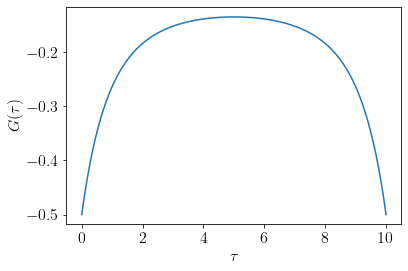

In [8]:
taus = np.linspace(0, beta, 1000)
plt.plot(taus, eval_gtau(taus))
plt.xlabel(r"$\tau$")
plt.ylabel(r"$G(\tau)$")

## Reconstruct $g_l$ by numerical integration

$$
g_l = \int_0^\beta d\tau U_l(\tau) G(\tau)
$$

In [9]:
gl_reconst = basis.u.overlap(eval_gtau)

## Reconstruct $g_l$ by sparse sampling (fitting)

In [10]:
smpl = irbasis3.TauSampling(basis)
print("Sampling points: ", smpl.sampling_points)
print("Condition number: ", smpl.cond)
gl_reconst_sparse = smpl.fit(eval_gtau(smpl.sampling_points))

Sampling points:  [0.01254038 0.02508075 0.0846084  0.17969895 0.31247002 0.48595941
 0.70421951 0.97237343 1.29652855 1.68336935 2.13916506 2.66791199
 3.26855641 3.93189993 4.6387471  5.3612529  6.06810007 6.73144359
 7.33208801 7.86083494 8.31663065 8.70347145 9.02762657 9.29578049
 9.51404059 9.68752998 9.82030105 9.9153916  9.97491925 9.98745962]
Condition number:  5.897702173686458


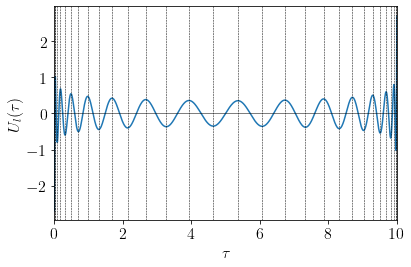

In [11]:
plt.plot(taus, basis.u[-1](taus))
plt.plot(taus, np.zeros_like(taus), ls="-", color="k", marker="", lw=0.5)
#plt.plot(smpl.sampling_points, np.full(smpl.sampling_points.size, 0.0), ls="", marker="x")
for x in smpl.sampling_points:
    plt.axvline(x=x, ls="--", lw=0.5, color="k")
plt.xlabel(r"$\tau$")
plt.ylabel(r"$U_l(\tau)$")
plt.xlim([0, beta])
plt.tight_layout()
plt.savefig("sampling_points_tau.pdf")

## Comparison

Text(0, 0.5, '$|g_l|$')

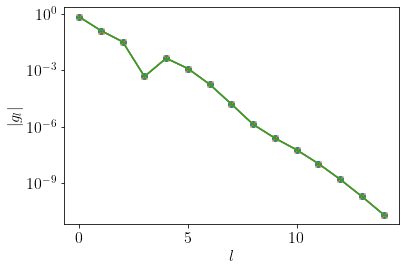

In [12]:
gl = -basis.s * rhol
plt.semilogy(np.abs(gl[::2]), marker="o")
plt.semilogy(np.abs(gl_reconst[::2]), marker="x")
plt.semilogy(np.abs(gl_reconst_sparse[::2]), marker="+")
plt.xlabel(r"$l$")
plt.ylabel(r"$|g_l|$")

Sampling points:  [ 0.          0.34482759  0.68965517  1.03448276  1.37931034  1.72413793
  2.06896552  2.4137931   2.75862069  3.10344828  3.44827586  3.79310345
  4.13793103  4.48275862  4.82758621  5.17241379  5.51724138  5.86206897
  6.20689655  6.55172414  6.89655172  7.24137931  7.5862069   7.93103448
  8.27586207  8.62068966  8.96551724  9.31034483  9.65517241 10.        ]
Condition number:  29141951701.728844
[ 6.70186062e-09 -1.67791675e-08  7.57710511e-09 -1.18136406e-08
  3.55545769e-09 -2.88893981e-09 -3.12664830e-10  2.97553653e-09
 -2.43852886e-09  5.52368783e-09 -3.04764632e-09  5.69128654e-09
 -2.70401860e-09  4.57009573e-09 -1.95240557e-09  3.06684958e-09
 -1.18689006e-09  1.75020282e-09 -6.09169681e-10  8.46428467e-10
 -2.60085446e-10  3.40733315e-10 -8.94510457e-11  1.10359841e-10
 -2.33818446e-11  2.70993582e-11 -4.15016210e-12  4.50337622e-12
 -3.77080377e-13  3.80943361e-13]


/usr/local/lib/python3.9/site-packages/irbasis3/sampling.py:40: ConditioningWarning: Sampling matrix is poorly conditioned (cond = 2.9e+10)
  warn("Sampling matrix is poorly conditioned (cond = %.2g)"


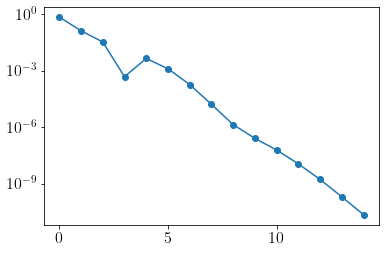

In [13]:
# Bad case with a uniform mesh
smpl_bad = irbasis3.TauSampling(basis, sampling_points=np.linspace(0, beta, basis.size))
print("Sampling points: ", smpl_bad.sampling_points)
print("Condition number: ", smpl_bad.cond)
gl_reconst_sparse_bad = smpl_bad.fit(eval_gtau(smpl_bad.sampling_points))
plt.semilogy(np.abs(gl_reconst_sparse_bad[::2]), marker='o')
print(gl_reconst_sparse_bad - gl) # You can see that the error is larger.

## Sparse sampling in Matsubara

Sampling frequencies:  [-229 -217  -93  -55  -39  -29  -23  -17  -15  -13  -11   -9   -7   -5
   -3   -1    1    3    5    7    9   11   13   15   17   23   29   39
   55   93  219  229]
Condition number:  11.263335632185683


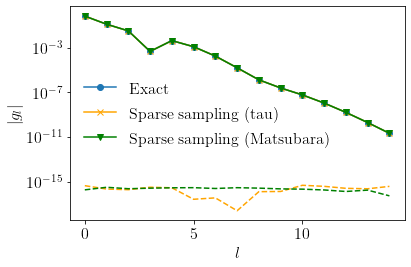

In [59]:
def eval_giv(v):
    uhat_val = basis.uhat(v)
    return uhat_val.T @ gl

smpl_matsu = irbasis3.MatsubaraSampling(basis)
print("Sampling frequencies: ", smpl_matsu.sampling_points)
print("Condition number: ", smpl_matsu.cond)
gl_reconst_sparse_matsu = smpl_matsu.fit(eval_giv(smpl_matsu.sampling_points))

gl = -basis.s * rhol
plt.semilogy(np.abs(gl[::2]), marker="o", label="Exact")
plt.semilogy(np.abs(gl_reconst_sparse[::2]), marker="x",
    label="Sparse sampling (tau)", color="orange")
plt.semilogy(np.abs(gl_reconst_sparse_matsu[::2]), marker="v",
    label="Sparse sampling (Matsubara)", color="green")
plt.semilogy(np.abs(gl_reconst_sparse[::2]-gl[::2]), marker="", ls='--', label="",
    color="orange")
plt.semilogy(np.abs(gl_reconst_sparse_matsu[::2]-gl[::2]), marker="", ls='--', label="",
    color="green")
plt.legend(loc="best", frameon=False)
plt.xlabel(r"$l$")
plt.ylabel(r"$|g_l|$")
plt.tight_layout()
plt.savefig("gl_sparse.pdf")

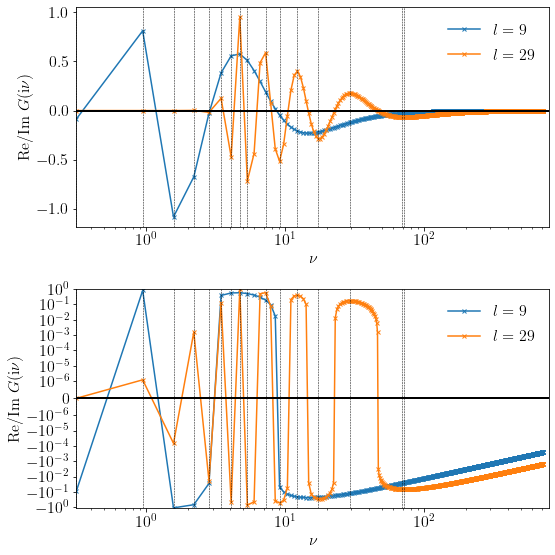

In [46]:
get_nonzero_part = lambda l, data: data.imag if l%2==0 else data.real 

fig, axes = plt.subplots(2, figsize=(8,8))

nmax = int(10*(smpl_matsu.sampling_points.max()//2))
nvec = 2*np.arange(-nmax,nmax)+1
vvec = nvec * np.pi/beta
for l in [9, basis.size-1]:
    for ax in axes:
        ax.plot(vvec, get_nonzero_part(l, basis.uhat[l](nvec)), 
            label=f"$l={l}$", ls="-", marker="x", ms=4)

for n in smpl_matsu.sampling_points:
    for ax in axes:
        ax.axvline(n*np.pi/beta, ls="--", lw=0.5, color="k")
        ax.axhline(0, ls="-", lw=0.25, color="k")

for ax in axes:
    ax.legend(frameon=False)
    ax.set_xlabel(r"$\nu$")
    ax.set_ylabel(r"Re/Im $G(\mathrm{i}\nu)$")

#axes[0].set_xlim([0, 1.5*smpl_matsu.sampling_points.max() * np.pi/beta])
axes[0].set_xlim([np.pi/beta, None])
axes[0].set_xscale("log")
axes[1].set_xlim([np.pi/beta, None])
axes[1].set_xscale("log")
axes[1].set_yscale("symlog", linthresh=1e-6)

plt.tight_layout()
plt.savefig("uhat.pdf")